In [ ]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import torch
import numpy as np
import stanza
import json
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine
import re

In [ ]:
# Initialize Stanza for Estonian
stanza.download("et")
nlp = stanza.Pipeline("et", processors="tokenize,pos,lemma,depparse")

In [ ]:
# Load EstBERT tokenizer and model
model_name = "tartuNLP/EstBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: et (Estonian) ...
INFO:stanza:File exists: /root/stanza_resources/et/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: et (Estonian):
| Processor | Package      |
----------------------------
| tokenize  | edt          |
| mwt       | edt          |
| pos       | edt_nocharlm |
| lemma     | edt_nocharlm |
| depparse  | edt_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Processing review: Super maitsvad söögid, joogid ning meeldiv ja kiire teenindus.

Aspects extracted: [{'text': 'söögid', 'start': 15, 'end': 21}, {'text': 'joogid', 'start': 23, 'end': 29}, {'text': 'teenindus', 'start': 52, 'end': 61}]
Opinions extracted: [{'text': 'super maitsvad', 'start': 0, 'end': 14}, {'text': 'meeldiv', 'start': 35, 'end': 42}, {'text': 'kiire', 'start': 46, 'end': 51}]


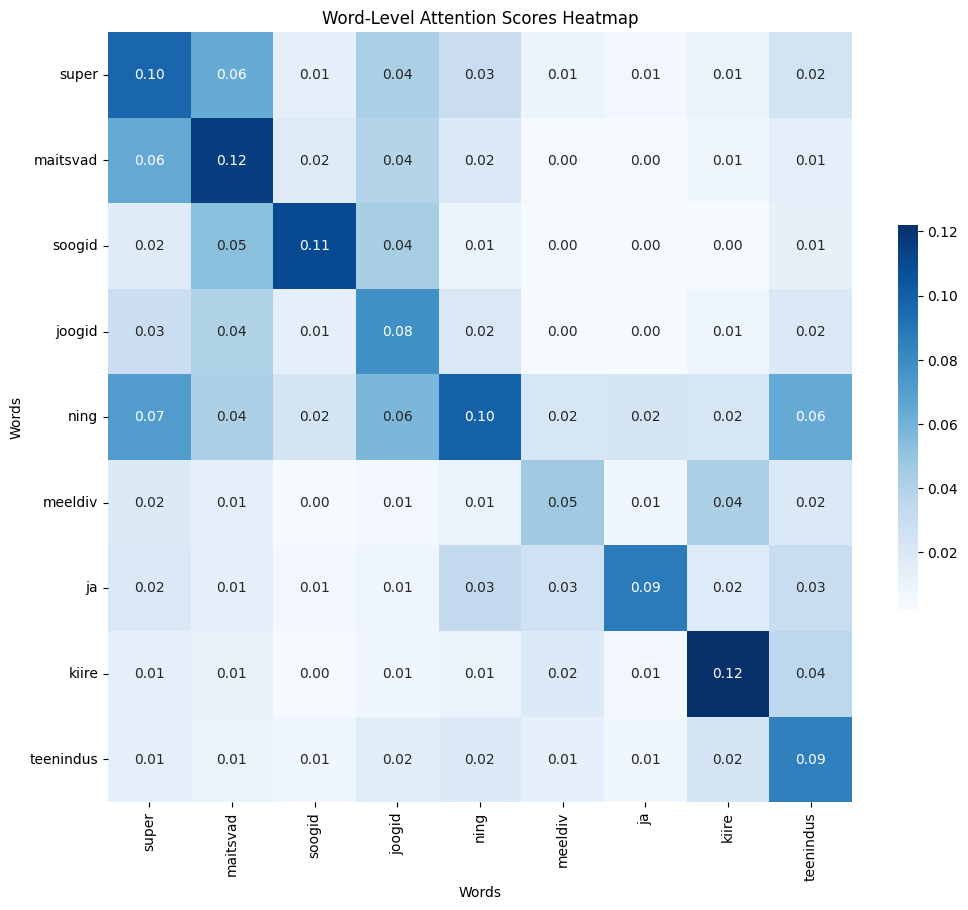

[
    {
        "review_text": "Super maitsvad söögid, joogid ning meeldiv ja kiire teenindus.",
        "aspects": [
            {
                "aspect term": {
                    "start": 52,
                    "end": 61,
                    "text": "teenindus"
                },
                "opinion term": {
                    "start": 46,
                    "end": 51,
                    "text": "kiire"
                },
                "polarity": "neutral"
            },
            {
                "aspect term": {
                    "start": 52,
                    "end": 61,
                    "text": "teenindus"
                },
                "opinion term": {
                    "start": 35,
                    "end": 42,
                    "text": "meeldiv"
                },
                "polarity": "positive"
            }
        ]
    }
]


In [ ]:
# Check if a word is punctuation
def is_punctuation(word):
    return bool(re.fullmatch(r"\W+", word))

# Extract aspect and opinion terms from a sentence
def extract_aspects_opinions(text):
    aspect_terms = []
    opinion_terms = []

    doc = nlp(text.lower())

    for sentence in doc.sentences:
        for i, word in enumerate(sentence.words):
            if is_punctuation(word.text):
                continue
            if word.upos == "NOUN" and word.deprel != "nmod" and sentence.words[i - 1].deprel != "cop":
                aspect_terms.append({
                    "text": word.text.strip(),
                    "start": word.start_char,
                    "end": word.end_char
                })

            if word.upos == "ADJ" and word.deprel in ["acl", "conj"]:
                if sentence.words[i - 1].deprel == "nmod":
                    full_text = " ".join([sentence.words[i - 1].text.strip(), word.text.strip()])
                    opinion_terms.append({
                        "text": full_text,
                        "start": sentence.words[i - 1].start_char,
                        "end": word.end_char
                    })
                else:
                    opinion_terms.append({
                    "text": word.text.strip(),
                    "start": word.start_char,
                    "end": word.end_char
                })
            elif word.upos == "NOUN" and i > 0 and sentence.words[i - 1].deprel == "cop":
                opinion_terms.append({
                    "text": word.text.strip(),
                    "start": word.start_char,
                    "end": word.end_char
                })

    return aspect_terms, opinion_terms

# Map tokens to words and aggregate subwords
def get_token_word_mapping(tokens):
    word_ids = tokens.word_ids()
    token_labels = tokens.tokens()

    word_to_token_idxs = {}
    word_list = []

    for idx, word_id in enumerate(word_ids):
        if word_id is not None:
            word_to_token_idxs.setdefault(word_id, []).append(idx)

    valid_word_ids = sorted(set([wid for wid in word_ids if wid is not None]))

    for word_id in valid_word_ids:
        token_idxs = word_to_token_idxs[word_id]
        word_tokens = [token_labels[idx] for idx in token_idxs]
        # Join subwords back into whole word
        word = "".join([t.replace("##", "") if t.startswith("##") else t for t in word_tokens])

        if is_punctuation(word):
            continue

        word_list.append({
            "word": word,
            "token_idxs": token_idxs
        })

    return word_list, word_to_token_idxs

# Get the attention scores matrix
def get_attention_scores(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens, output_attentions=True)

    attentions = outputs.attentions
    attention_matrix = attentions[-1].squeeze(0).mean(dim=0).cpu().numpy()

    return tokens, attention_matrix

# Aggregate attention matrix from tokens to words
def aggregate_attention_by_words(tokens, attention_matrix):
    word_list, word_to_token_idxs = get_token_word_mapping(tokens)

    num_words = len(word_list)
    word_attention_matrix = np.zeros((num_words, num_words))

    for i, word_i in enumerate(word_list):
        idxs_i = word_i['token_idxs']
        for j, word_j in enumerate(word_list):
            idxs_j = word_j['token_idxs']

            sub_scores = [attention_matrix[idx_i, idx_j] for idx_i in idxs_i for idx_j in idxs_j]
            word_attention_matrix[i, j] = np.mean(sub_scores)

    word_labels = [w['word'] for w in word_list]
    return word_attention_matrix, word_labels

# Threshold adjustment (manual value instead of dynamic)
def fixed_threshold():
    return 0.01

# Find top opinions for each aspect based on aggregated attention
def find_top_opinions_for_aspect(tokens, attention_matrix, aspect_terms, opinion_terms, top_n=2):
    word_list, word_to_token_idxs = get_token_word_mapping(tokens)
    word_attention_matrix, word_labels = aggregate_attention_by_words(tokens, attention_matrix)

    threshold = fixed_threshold()

    aspect_to_opinions = {}

    # Build lookup dictionaries
    aspect_words = [aspect["text"].lower() for aspect in aspect_terms]
    opinion_words = [opinion["text"].lower() for opinion in opinion_terms]
    word_label_to_index = {word.lower(): idx for idx, word in enumerate(word_labels)}

    for aspect in aspect_terms:
        aspect_word = aspect["text"].lower()

        if aspect_word not in word_label_to_index:
            continue

        aspect_idx = word_label_to_index[aspect_word]
        candidate_opinions = []

        for opinion in opinion_terms:
            opinion_word = opinion["text"].lower()

            if opinion_word not in word_label_to_index:
                continue

            opinion_idx = word_label_to_index[opinion_word]
            score = word_attention_matrix[aspect_idx, opinion_idx]

            if score >= threshold:
                candidate_opinions.append((opinion, score))

        sorted_candidates = sorted(candidate_opinions, key=lambda x: x[1], reverse=True)[:top_n]
        aspect_to_opinions[aspect["text"]] = sorted_candidates

    return aspect_to_opinions, word_attention_matrix, word_labels

# Plot word-level attention heatmap
def plot_attention_heatmap(attention_matrix, labels):
    plt.figure(figsize=(12, 10))
    sns.heatmap(attention_matrix, xticklabels=labels, yticklabels=labels,
                cmap="Blues", annot=True, fmt=".2f", cbar_kws={"shrink": 0.5})
    plt.title("Word-Level Attention Scores Heatmap")
    plt.xlabel("Words")
    plt.ylabel("Words")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Compute sentence embedding
def compute_sentence_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)

    hidden_states = outputs.logits
    sentence_embedding = hidden_states.mean(dim=1).squeeze().cpu().numpy()

    return sentence_embedding

# Assign sentiment polarity
def assign_sentiment_polarity(opinion_terms):
    sentiment_labels = {
        "positive": compute_sentence_embedding("positiivne"),
        "negative": compute_sentence_embedding("negatiivne"),
        "neutral": compute_sentence_embedding("neutraalne")
    }

    opinion_polarities = {}
    for opinion in opinion_terms:
        opinion_embedding = compute_sentence_embedding(opinion["text"])
        best_match = max(sentiment_labels.keys(),
                         key=lambda label: 1 - cosine(opinion_embedding, sentiment_labels[label]))
        opinion_polarities[opinion["text"]] = best_match

    return opinion_polarities

# Full review processing
def process_reviews(reviews):
    results = []

    for review in reviews:
        print(f"\nProcessing review: {review}\n")
        aspects, opinions = extract_aspects_opinions(review)

        print(f"Aspects extracted: {aspects}")
        print(f"Opinions extracted: {opinions}")

        if not aspects:
            print("No aspects found! Skipping...\n")
            continue

        tokens, attention_matrix = get_attention_scores(review)

        aspect_opinion_pairs, word_attention_matrix, word_labels = find_top_opinions_for_aspect(
            tokens, attention_matrix, aspects, opinions, top_n=2)

        opinion_polarities = assign_sentiment_polarity(opinions)

        aspect_list = []
        for aspect_text, opinion_list in aspect_opinion_pairs.items():
            for opinion, score in opinion_list:
                aspect_entry = {
                    "aspect_term": {
                        "start": next(a["start"] for a in aspects if a["text"] == aspect_text),
                        "end": next(a["end"] for a in aspects if a["text"] == aspect_text),
                        "text": aspect_text
                    },
                    "opinion_term": {
                        "start": opinion["start"],
                        "end": opinion["end"],
                        "text": opinion["text"],
                    },
                    "polarity": opinion_polarities.get(opinion["text"], "neutral")
                }
                aspect_list.append(aspect_entry)

        results.append({
            "review_text": review,
            "triplets": aspect_list
        })

        # Plot aggregated attention heatmap
        plot_attention_heatmap(word_attention_matrix, word_labels)

    return results

# Example review
reviews = ["Super maitsvad söögid, joogid ning meeldiv ja kiire teenindus."]

# Process and output
output_data = process_reviews(reviews)

# Output results as JSON
print(json.dumps(output_data, indent=4, ensure_ascii=False))